In [45]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy import integrate as integrate
import pandas as pd
from scipy.optimize import basinhopping
from scipy.special import erf
from matplotlib import cm
import scipy.integrate
from scipy import integrate as integrate

In [46]:
from getdist import plots, MCSamples
import getdist
import time
from scipy.integrate import odeint

In [47]:
plt.style.use('default')
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [4]:
import os

os.environ["OMP_NUM_THREADS"] = "1"

In [124]:
def E( parameters,z):  
    omega=parameters[0]
    alpha=parameters[1]
    #Ho= parameters[2]
    #print(alpha)
    sol = odeint (KG_eqn, y0(alpha), t, args=(parameters,))
    a=sol[:,0]
    phi=sol[:,1]
    phi_dot = sol[:,2]
    rho_m = sol[:,3]
    kappa_alpha = kappa(alpha)
    V = (1/2)*kappa_alpha/(phi)**(alpha)
    rho_phi = 0.5*phi_dot**2 + V
    omega_exp = rho_m/(rho_phi+rho_m)
    i = np.where(omega_exp>=omega)
    i=i[0]
    if (len(i)>1):
        i=i[-1]
    #else:
        #i=i[0]
    #print(i)
    rho_critical = rho_m[i]+rho_phi[i]
    a_z = 1/(1+z)
    #print(sol[i,0])
    a = a/sol[i,0]
    j = np.where(a >= a_z)[0]
    j=j[0]
    #print(j)
    omega_m_theo = rho_m[j]/(rho_critical)
    omega_phi_theo = rho_phi[j]/(rho_critical)
    return np.sqrt(omega_m_theo+omega_phi_theo)

In [89]:
def E_sol(rho_critical,rho_m,rho_phi,a,z):

    a_z = 1/(1+z)
    #print(sol[i,0])
    
    j = np.where(a >= a_z)[0]
    #print(j)
    j=j[0]
    #print(j)
    omega_m_theo = rho_m[j]/(rho_critical)
    omega_phi_theo = rho_phi[j]/(rho_critical)
    return np.sqrt(omega_m_theo+omega_phi_theo)    

In [50]:
def erf_new(x):
    return ((4/np.pi)**(1/2))*(erf(x)-erf(0))

In [51]:
def alphaf(parameters,sigma_Ho,sigma,z,E_array):
    #sigma,z,H_obs are vectors

    n = len(sigma)
    alpha0=1/(sigma_Ho)**2
    for i in range(n):
        alpha0 = alpha0 + (E_array[i]/sigma[i])**2
        
    return alpha0

In [52]:
def beta(parameters,Ho,sigma_Ho,H_obs,sigma,z,E_array):
    n = len(sigma)
    beta0=Ho/((sigma_Ho)**2)
    for i in range(n):
        beta0 = beta0 + (E_array[i]*H_obs[i]/((sigma[i])**2))
        
    return beta0
    

In [53]:
def gamma(Ho,sigma_Ho,H_obs,sigma,E_array):
    n = len(sigma)
    gamma0=(Ho/(sigma_Ho))**2
    for i in range(n):
        gamma0 = gamma0 + (H_obs[i]/sigma[i])**2
        
    return gamma0 

In [186]:
def Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    
    omega=parameters[0]
    alpha=parameters[1]
    t_initial = 10**(-5)
    t_final = 150
    dt = 10**(-3)
    t = np.arange(0., t_final, dt)
    start = time.time()
    sol = odeint (KG_eqn, y0(alpha), t, args=(parameters,))
    end= time.time()
    a=sol[:,0]
    phi=sol[:,1]
    phi_dot = sol[:,2]
    rho_m = sol[:,3]
    kappa_alpha = kappa(alpha)
    V = (1/2)*kappa_alpha/(phi)**(alpha)
    rho_phi = 0.5*phi_dot**2 + V
    omega_exp = rho_m/(rho_phi+rho_m)
    i = np.where(omega_exp>=omega)
    i=i[0]
    if (len(i)>1):
        i=i[-1]
    else:
        i=len(t)-1
    #print(i)
    rho_critical = rho_m[i]+rho_phi[i]
    a = a/sol[i,0]
    E_array = np.zeros(len(z_obs))
    
    #print(end-start)
    for i in range(len(z_obs)):
        
        E_array[i] = E_sol(rho_critical,rho_m,rho_phi,a,z_obs[i])
        
    #print(E_array)
    
    
    alpha0= alphaf(parameters,sigma_Ho,sigma,z,E_array)
    beta0= beta(parameters,Ho,sigma_Ho,H_obs,sigma,z,E_array)
    gamma0= gamma(Ho,sigma_Ho,H_obs,sigma,E_array)
    LH1= (1/(4*alpha0*((sigma_Ho)**2)))**(1/2)
    LH2= np.exp(-gamma0/2+(((beta0)**2)/(2*alpha0)))
    LH3 = 1+ erf_new(beta0/((2*alpha0)**(1/2)))
    
    return (LH1*LH2*LH3)

In [187]:
def Chi_sq(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    return (-2*np.log(Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z)))

In [188]:
def log_likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    return np.log(Likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z))

In [189]:
def log_prior(parameters):
    omega,alpha = parameters
    if 0.01 < omega < 0.70 and 0.00001 < alpha < 5:
        return 0.0
    return -np.inf

In [190]:
def log_probability(parameters,Ho,sigma_Ho,H_obs,sigma,z):
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
   
    return lp + log_likelihood(parameters,Ho,sigma_Ho,H_obs,sigma,z)

In [59]:
print(H([0.30,0.01,70],1.965))

NameError: name 'H' is not defined

In [191]:
def kappa(alpha):
    #print(alpha)
    #print(type(alpha))
    p1= (8*alpha+32)/(3*alpha+6)
    p2= ((2*(alpha**2)+4*alpha)/3)**(alpha/2)
    #print(f"kappa:{p1*p2}")
    return p1*p2

In [192]:
print(kappa(0.5))
print((1/12)*kappa(0.1)*0.13486911**(-0.1))

4.586125402580961
0.48047102316806106


In [193]:
def y0(alpha):
    t0 = 10**(-5)
    a_initial = t0**(2/3)
    phi_initial =   ((2*alpha*(alpha+2)/3)**(1/2))*((t0)**(2/(alpha+2)))
   
    phi_dot_initial = (2/(alpha+2))*(phi_initial)/t0
    
    Ho = 70 # Hubble parameter today in units of 100 km/s/Mpc (Planck 2015)
    rho_cr0 = 3*Ho**2/(8*np.pi)
    #h = 0.678 # Hubble parameter today in units of 100 km/s/Mpc (Planck 2015)
    #rho_cr0 = 8.0992*(h**2)*10**(-47) / (2.435*10**18)**4
    # calculate the matter density today
    Omega_m = 0.28
    rho_m0 = Omega_m*rho_cr0
    rho_initial = rho_m0/(a_initial**3) # initial value for the matter density
    
    return a_initial,phi_initial,phi_dot_initial,rho_initial

In [63]:
t_initial = 10**(-5)
t_final = 150
dt = t_initial
t = np.arange(0., t_final, dt)


    

In [181]:
def KG_eqn(y, t, parameters):
    a,phi,phi_dot,rho_m = y
    alpha=parameters[1]
    kappa_alpha = kappa(alpha)
    mp = 1
    V = (1/2)*kappa_alpha*mp**2/(phi)**(alpha)
    rho_phi = 0.5*phi_dot**2 + V
    Hubble_rate = np.sqrt((8*np.pi/3)* (rho_phi + rho_m))
    dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)), -3*rho_m*Hubble_rate ]
    return dydt

In [65]:
parameters = [0.30,0.01]
Ho=70

In [27]:
#from scipy.integrate import odeint
start = time.time()
sol = odeint(KG_eqn, y0(0.01), t, args=(parameters,))
end= time.time()
print(end-start)

1.7523729801177979


In [63]:
print(sol[0:1678,2])

[0.12197251 1.24648993 1.23390587 ... 1.18724844 1.18724484 1.18724124]


In [66]:
a = sol[:,0]
phi=sol[:,1]
phi_dot=sol[:,2]
rho_m = sol[:,3]
H=[]
alpha = 0.01
print(phi,phi_dot,rho_m)
kappa_alpha = kappa(alpha)
V = (1/2)*kappa_alpha/(phi)**(alpha)
rho_phi = 0.5*phi_dot**2 + V
Hubble_rate = np.sqrt((8*np.pi/3)* (rho_phi + rho_m))
print(V)

print(Hubble_rate[16906])


[1.22582372e-06 3.09880850e-05 5.60806417e-05 ... 3.69608857e+00
 3.69608869e+00 3.69608880e+00] [0.12197251 2.63527233 2.41242971 ... 0.01144774 0.01144774 0.01144774] [1.63770436e+12 5.11923111e+08 1.30273840e+08 ... 1.39566894e-11
 1.39553669e-11 1.39540397e-11]
[2.98289726 2.88808937 2.87100829 ... 2.56947947 2.56947947 2.56947947]
5.53550817212488


In [67]:
Data = pd.read_csv("Hdata - Table 1.csv")
print(Data)
Data = Data.to_numpy()
z_obs = Data[:,1]
H_obs = Data[:,2]
sigma_obs = Data[:,3]
print(z_obs)

    Unnamed: 0      z      H  Sigma
0          NaN  0.070   69.0   19.6
1          NaN  0.100   69.0   12.0
2          NaN  0.120   68.6   26.2
3          NaN  0.170   83.0    8.0
4          NaN  0.179   75.0    4.0
5          NaN  0.199   75.0    5.0
6          NaN  0.200   72.9   29.6
7          NaN  0.270   77.0   14.0
8          NaN  0.280   88.8   36.6
9          NaN  0.350   76.3    5.6
10         NaN  0.352   83.0   14.0
11         NaN  0.400   95.0   17.0
12         NaN  0.440   82.6    7.8
13         NaN  0.480   97.0   62.0
14         NaN  0.593  104.0   13.0
15         NaN  0.600   87.9    6.1
16         NaN  0.680   92.0    8.0
17         NaN  0.730   97.3    7.0
18         NaN  0.781  105.0   12.0
19         NaN  0.875  125.0   17.0
20         NaN  0.880   90.0   40.0
21         NaN  0.900  117.0   23.0
22         NaN  1.037  154.0   20.0
23         NaN  1.300  168.0   17.0
24         NaN  1.430  177.0   18.0
25         NaN  1.530  140.0   14.0
26         NaN  1.750  202.0

In [68]:
Ho= 68
sigma_Ho=2.8

In [41]:
start = time.time()
print(E([0.30,0.01],z_obs))
end = time.time()
print(end-start)

ValueError: operands could not be broadcast together with shapes (15000000,) (28,) 

In [194]:
start = time.time()
print(Chi_sq([0.30,0.0001],68,2.8,H_obs,sigma_obs,z_obs))
end = time.time()
print(end-start)

18.01084830009045
0.29898905754089355


<ipython-input-181-ee1eba76dead>:9: RuntimeWarning: overflow encountered in double_scalars
  dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)), -3*rho_m*Hubble_rate ]
<ipython-input-186-53f91b677e93>:17: RuntimeWarning: divide by zero encountered in true_divide
  V = (1/2)*kappa_alpha/(phi)**(alpha)


In [199]:
best_fit_params2 = minimize (Chi_sq,x0=[0.30,0.01],args=(68,2.8,H_obs,sigma_obs,z_obs),method='L-BFGS-B',bounds=[(0,2),(0,5)])
print(best_fit_params2)

      fun: 17.957057596493936
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.       , -0.3511623])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 186
      nit: 3
     njev: 62
   status: 0
  success: True
        x: array([0.3       , 0.01039639])


In [95]:
best_fit_params2 = minimize (Chi_sq,x0=[0.30,0],args=(73.8,2.4,H_obs,sigma_obs,z_obs),method='L-BFGS-B',bounds=[(0,1),(-0.25,0.25)])
print(best_fit_params2)
print(np.round((best_fit_params2.x),2))
print(np.round((best_fit_params2.fun),2))

<ipython-input-52-773b540d9751>:6: RuntimeWarning: divide by zero encountered in double_scalars
  V = (1/2)*kappa_alpha*mp**2/(phi)**(alpha)
<ipython-input-52-773b540d9751>:9: RuntimeWarning: invalid value encountered in double_scalars
  dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)), -3*rho_m*Hubble_rate ]
<ipython-input-52-773b540d9751>:9: RuntimeWarning: divide by zero encountered in double_scalars
  dydt = [a*Hubble_rate,phi_dot,-3*Hubble_rate*phi_dot+ 0.5*kappa_alpha*alpha/(phi**(alpha+1)), -3*rho_m*Hubble_rate ]
C:\Users\bansa\anaconda3\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-77-319b4e442e75>:12: RuntimeWarning: divide by zero encountered in true_divide
  V = (1/2)*kappa_alpha/(phi)**(alpha)
<ipython-input-19-9bcb52307672>:4: RuntimeWarnin

IndexError: index -1 is out of bounds for axis 0 with size 0

In [164]:
import emcee
from multiprocessing import Pool
pos = best_fit_params2.x + 1e-4 * np.random.randn(100, 2)
nwalkers, ndim = pos.shape
print("done0")
filename = "Ho68_phiCDM.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)
print("done1")

#print(best_fit_params)
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(68,2.8,H_obs,sigma_obs,z_obs),backend=backend
)
start = time.time()
sampler.run_mcmc(pos, 3000, progress=True);
end = time.time()
print(end-start)

done0
done1


  0%|                                                                              | 3/3000 [00:58<16:15:55, 19.54s/it]<ipython-input-159-63978bf8eec9>:17: RuntimeWarning: divide by zero encountered in true_divide
  V = (1/2)*kappa_alpha/(phi)**(alpha)
100%|███████████████████████████████████████████████████████████████████████████| 3000/3000 [15:16:58<00:00, 18.34s/it]

55039.00506544113


In [165]:
tau = sampler.get_autocorr_time()
tau = sampler.get_autocorr_time()
burnin =  int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(flat_samples.shape))

burn-in: 75
thin: 16
flat chain shape: (18200, 2)


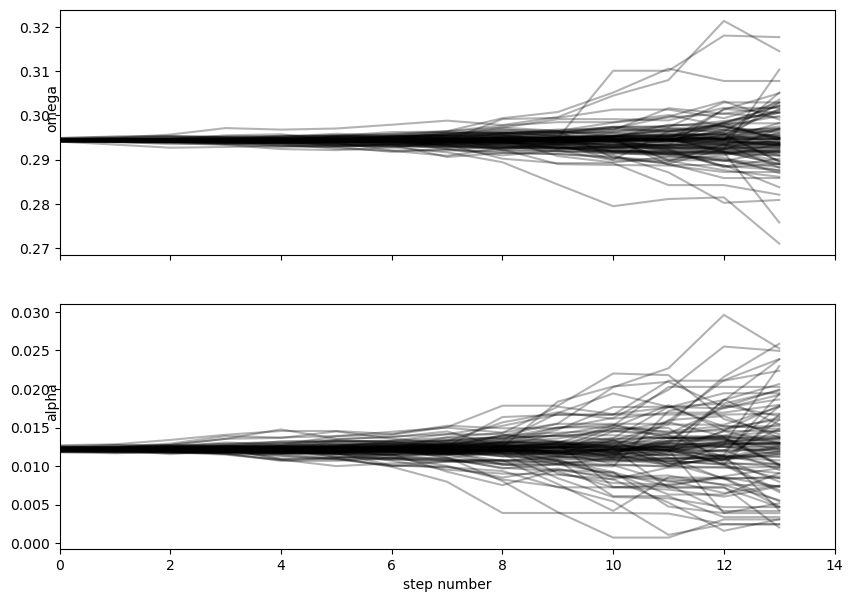

In [201]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["omega", "alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(0,0.60)

axes[-1].set_xlabel("step number");

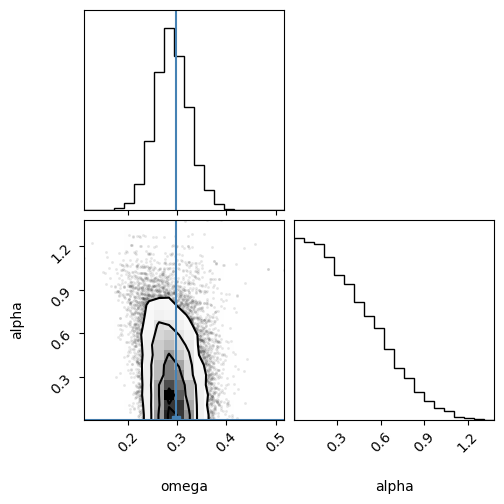

In [166]:
import corner
labels = ["omega","alpha"]
fig = corner.corner(
    flat_samples, labels=labels, truths= best_fit_params2.x
);

In [167]:
ndim = 2
nsamp = 132400
samps = flat_samples
#samps2 = flat_samples2

In [172]:
names = ["omega","alpha"]
labels =  ["\Omega_{mo}","alpha"]
samples = MCSamples(samples=samps,names = names, labels = labels)
#samples2 = MCSamples(samples=samps2,names = names, labels = labels)

Removed no burn in


In [1]:
g = plots.get_single_plotter()
ax1= g.get_axes()
samples.updateSettings({'contours': [0.001,0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 4
g.plot_2d(samples, 'omega', 'alpha');
ax1.set_ylim(0,1.2)
ax1.set_xlim(0,0.5)

NameError: name 'plots' is not defined

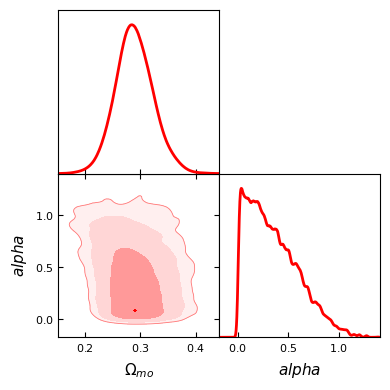

In [180]:
from matplotlib import cm
samples.updateSettings({'contours': [0.001,0.68, 0.95, 0.99]})
g = plots.get_subplot_plotter(subplot_size=2)
g.settings.num_plot_contours = 4
g.triangle_plot([samples], filled=True,contour_lws=2,contour_colors=['red']);
#g.export("BAO_XCDM.png")

In [ ]:
g = plots.get_single_plotter()
samples.updateSettings({'contours': [0.007,0.68, 0.95, 0.99]})
#samples2.updateSettings({'contours': [0.001,0.68, 0.95, 0.99]})
g.settings.num_plot_contours = 4
g.plot_2d([samples,samples2], 'omega', 'alpha',lws=[1],filled=[False],colors=["Black"],ls=["solid"]);
#g.plot_2d([samples2], 'omega', 'omega_lambda',lws=[1],filled=[False],colors=["Black"],ls=["solid"]);
g.add_legend(['$H_o=68 \pm 2.8$'], bbox_to_anchor=(0.5,0.9));
ax1= g.get_axes()

ax1.set_ylim(0,1.4)
ax1.set_xlim(0,0.6)
ax1.xaxis.set_major_locator(MultipleLocator(0.1))
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which ='both',direction='in')
ax1.tick_params(which='major', length=7)
ax1.tick_params(which='minor', length=4)
ax1.text(0.4,0.23,"Acceleration",Rotation="10",weight="bold")
ax1.text(0.4,0.12,"Deceleration",Rotation="10",weight="bold")
ax1.text(0.018,0.88,"Open",Rotation="-20",weight="bold")
ax1.text(0.02,0.95,"Closed",Rotation="-20",weight="bold")
ax1.text(0.02,1.2,"No Big Bang",Rotation="45",size="x-small")

ax2 = ax1.twinx()
ax2.tick_params(direction='in')
ax2.set_ylim(0,1.4)
ax3= ax1.twiny()
ax3.tick_params(direction='in')
ax3.set_xlim(0,0.6)
ax3.xaxis.set_major_locator(MultipleLocator(0.1))
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_major_locator(MultipleLocator(0.2))
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which ='both',direction='in')
ax2.tick_params(which='major', length=7)
ax2.tick_params(which='minor', length=4)
ax3.tick_params(which ='both',direction='in')
ax3.tick_params(which='major', length=7)
ax3.tick_params(which='minor', length=4)




In [174]:
from IPython.display import display, Math

for i in range(2):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    minimum = mcmc[1]-q[0]
    maximum = mcmc[1]+q[1]
    #print(f"{minimum} $\le \Omega \ge$ {maximum}")
    txt = "\mathrm{{{3}}} = {0:.2f}_{{{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], mcmc[1]-q[0], mcmc[1]+q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>